In [1]:
import torch
import torchvision

test_data = torchvision.datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor()
)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=True)
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

img, label = next(iter(test_loader))
img = img.reshape(1, 28, 28).numpy()

In [5]:
import numpy as np
import tvm
from tvm import relax
from tvm.ir.module import IRModule
from tvm.script import relax as R
from tvm.script import tir as T

import IPython

def code2html(code):
    """Helper function to use pygments to turn the code string into highlighted html."""
    import pygments
    from pygments.formatters import HtmlFormatter
    from pygments.lexers import Python3Lexer
    formatter = HtmlFormatter()
    html = pygments.highlight(code, Python3Lexer(), formatter)
    return "<style>%s</style>%s\n" % (formatter.get_style_defs(".highlight"), html)

[09:15:30] /home/ningzhangcaltech/Github_Repo/tvm/src/target/llvm/llvm_instance.cc:226: Error: Using LLVM 19.0.0git with `-mcpu=apple-latest` is not valid in `-mtriple=arm64-apple-macos`, using default `-mcpu=generic`
[09:15:30] /home/ningzhangcaltech/Github_Repo/tvm/src/target/llvm/llvm_instance.cc:226: Error: Using LLVM 19.0.0git with `-mcpu=apple-latest` is not valid in `-mtriple=arm64-apple-macos`, using default `-mcpu=generic`
[09:15:30] /home/ningzhangcaltech/Github_Repo/tvm/src/target/llvm/llvm_instance.cc:226: Error: Using LLVM 19.0.0git with `-mcpu=apple-latest` is not valid in `-mtriple=arm64-apple-macos`, using default `-mcpu=generic`


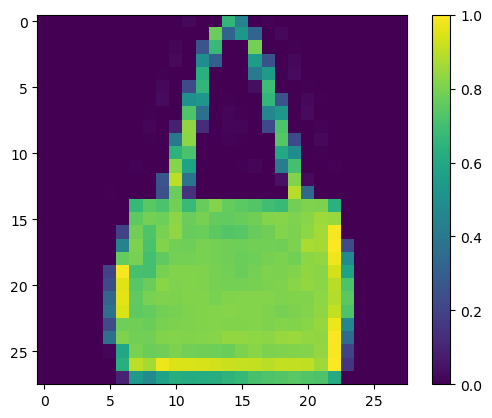

Class: Bag


In [2]:
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(img[0])
plt.colorbar()
plt.grid(False)
plt.show()

print("Class:", class_names[label[0]])

In [3]:
# Hide outputs
!wget -nc https://github.com/mlc-ai/web-data/raw/main/models/fasionmnist_mlp_params.pkl

File ‘fasionmnist_mlp_params.pkl’ already there; not retrieving.



In [6]:
import pickle as pkl

mlp_params = pkl.load(open("fasionmnist_mlp_params.pkl", "rb"))

data_nd = tvm.nd.array(img.reshape(1, 784))
nd_params = {k: tvm.nd.array(v) for k, v in mlp_params.items()}

In [7]:
@tvm.script.ir_module
class MyModuleMixture:
    @T.prim_func
    def linear0(X: T.Buffer((1, 784), "float32"),
                W: T.Buffer((128, 784), "float32"),
                B: T.Buffer((128,), "float32"),
                Z: T.Buffer((1, 128), "float32")):
        T.func_attr({"global_symbol": "linear0", "tir.noalias": True})
        Y = T.alloc_buffer((1, 128), "float32")
        for i, j, k in T.grid(1, 128, 784):
            with T.block("Y"):
                vi, vj, vk = T.axis.remap("SSR", [i, j, k])
                with T.init():
                    Y[vi, vj] = T.float32(0)
                Y[vi, vj] = Y[vi, vj] + X[vi, vk] * W[vj, vk]

        for i, j in T.grid(1, 128):
            with T.block("Z"):
                vi, vj = T.axis.remap("SS", [i, j])
                Z[vi, vj] =  Y[vi, vj] + B[vj]

    @R.function
    def main(x: R.Tensor((1, 784), "float32"),
             w0: R.Tensor((128, 784), "float32"),
             b0: R.Tensor((128,), "float32"),
             w1: R.Tensor((10, 128), "float32"),
             b1: R.Tensor((10,), "float32")):
        with R.dataflow():
            lv0 = R.call_dps_packed("linear0", (x, w0, b0), R.Tensor((1, 128), dtype="float32"))
            lv1 = R.call_dps_packed("env.relu", (lv0,), R.Tensor((1, 128), dtype="float32"))
            out = R.call_dps_packed("env.linear", (lv1, w1, b1), R.Tensor((1, 10), dtype="float32"))
            R.output(out)
        return out

In [8]:
@tvm.register_func("env.linear", override=True)
def torch_linear(x: tvm.nd.NDArray,
                 w: tvm.nd.NDArray,
                 b: tvm.nd.NDArray,
                 out: tvm.nd.NDArray):
    x_torch = torch.from_dlpack(x)
    w_torch = torch.from_dlpack(w)
    b_torch = torch.from_dlpack(b)
    out_torch = torch.from_dlpack(out)
    torch.mm(x_torch, w_torch.T, out=out_torch)
    torch.add(out_torch, b_torch, out=out_torch)

@tvm.register_func("env.relu", override=True)
def lnumpy_relu(x: tvm.nd.NDArray,
                out: tvm.nd.NDArray):
    x_torch = torch.from_dlpack(x)
    out_torch = torch.from_dlpack(out)
    torch.maximum(x_torch, torch.Tensor([0.0]), out=out_torch)

In [9]:
MyModuleWithParams = relax.transform.BindParams("main", nd_params)(MyModuleMixture)

In [11]:
ex = relax.build(MyModuleWithParams, target="llvm")
vm = relax.VirtualMachine(ex, tvm.cpu())

nd_res = vm["main"](data_nd)

pred_kind = np.argmax(nd_res.numpy(), axis=1)
print("MyModuleWithParams Prediction:", class_names[pred_kind[0]])

MyModuleWithParams Prediction: Bag


In [12]:
ftimer = vm.module.time_evaluator("main", tvm.cpu(), number=100)

print("MyModuleWithParams time-cost: %g ms" % (ftimer(data_nd).mean * 1000))

MyModuleWithParams time-cost: 0.212594 ms


In [13]:
#### 拿出模型 准备 tuning 

mod_linear = tvm.IRModule.from_expr(MyModuleMixture["linear0"].with_attr("global_symbol", "main"))
IPython.display.HTML(code2html(mod_linear.script()))

In [15]:
## tuning 

from tvm import meta_schedule as ms

database = ms.tune_tir(
    mod=mod_linear,
    target="llvm --num-cores=1",
    max_trials_global=64,
    num_trials_per_iter=64,
    work_dir="./tune_tmp",
    # task_name="main",
)
sch = ms.tir_integration.compile_tir(database, mod_linear, "llvm --num-cores=1")

2024-08-01 09:18:03 [INFO] Logging directory: ./tune_tmp/logs


2024-08-01 09:18:27 [INFO] LocalBuilder: max_workers = 8


[09:18:28] /home/ningzhangcaltech/Github_Repo/tvm/src/target/llvm/llvm_instance.cc:226: Error: Using LLVM 19.0.0git with `-mcpu=apple-latest` is not valid in `-mtriple=arm64-apple-macos`, using default `-mcpu=generic`
[09:18:28] /home/ningzhangcaltech/Github_Repo/tvm/src/target/llvm/llvm_instance.cc:226: Error: Using LLVM 19.0.0git with `-mcpu=apple-latest` is not valid in `-mtriple=arm64-apple-macos`, using default `-mcpu=generic`
[09:18:28] /home/ningzhangcaltech/Github_Repo/tvm/src/target/llvm/llvm_instance.cc:226: Error: Using LLVM 19.0.0git with `-mcpu=apple-latest` is not valid in `-mtriple=arm64-apple-macos`, using default `-mcpu=generic`


2024-08-01 09:18:30 [INFO] LocalRunner: max_workers = 1
2024-08-01 09:18:32 [INFO] [task_scheduler.cc:159] Initializing Task #0: "main"


,Name,FLOP,Weight,Speed (GFLOPS),Latency (us),Weighted Latency (us),Trials,Done
0,main,200832,1,N/A,N/A,N/A,0,


2024-08-01 09:18:32 [DEBUG] [task_scheduler.cc:318] 
 ID | Name |   FLOP | Weight | Speed (GFLOPS) | Latency (us) | Weighted Latency (us) | Trials | Done 
-----------------------------------------------------------------------------------------------------
  0 | main | 200832 |      1 |            N/A |          N/A |                   N/A |      0 |      
-----------------------------------------------------------------------------------------------------
Total trials: 0
Total latency (us): 0


Total trials: 0
Total latency (us): 0

2024-08-01 09:18:32 [INFO] [task_scheduler.cc:180] TaskScheduler picks Task #0: "main"
2024-08-01 09:18:33 [INFO] [task_scheduler.cc:193] Sending 64 sample(s) to builder


[09:18:33] /home/ningzhangcaltech/Github_Repo/tvm/src/target/llvm/llvm_instance.cc:226: Error: Using LLVM 19.0.0git with `-mcpu=apple-latest` is not valid in `-mtriple=arm64-apple-macos`, using default `-mcpu=generic`
[09:18:33] /home/ningzhangcaltech/Github_Repo/tvm/src/target/llvm/llvm_instance.cc:226: Error: Using LLVM 19.0.0git with `-mcpu=apple-latest` is not valid in `-mtriple=arm64-apple-macos`, using default `-mcpu=generic`
[09:18:33] /home/ningzhangcaltech/Github_Repo/tvm/src/target/llvm/llvm_instance.cc:226: Error: Using LLVM 19.0.0git with `-mcpu=apple-latest` is not valid in `-mtriple=arm64-apple-macos`, using default `-mcpu=generic`
[09:18:33] /home/ningzhangcaltech/Github_Repo/tvm/src/target/llvm/llvm_instance.cc:226: Error: Using LLVM 19.0.0git with `-mcpu=apple-latest` is not valid in `-mtriple=arm64-apple-macos`, using default `-mcpu=generic`
[09:18:33] /home/ningzhangcaltech/Github_Repo/tvm/src/target/llvm/llvm_instance.cc:226: Error: Using LLVM 19.0.0git with `-mcpu=

2024-08-01 09:18:42 [INFO] [task_scheduler.cc:195] Sending 64 sample(s) to runner
2024-08-01 09:19:01 [DEBUG] XGB iter   0: tr-p-rmse: 0.385006	tr-a-peak@32: 1.000000	tr-rmse: 0.264819	tr-rmse: 0.264819
2024-08-01 09:19:01 [DEBUG] XGB iter  25: tr-p-rmse: 0.050525	tr-a-peak@32: 0.999427	tr-rmse: 0.330838	tr-rmse: 0.330838
2024-08-01 09:19:01 [DEBUG] XGB iter  50: tr-p-rmse: 0.050522	tr-a-peak@32: 0.999427	tr-rmse: 0.330845	tr-rmse: 0.330845
2024-08-01 09:19:01 [DEBUG] XGB iter  75: tr-p-rmse: 0.050522	tr-a-peak@32: 0.999427	tr-rmse: 0.330845	tr-rmse: 0.330845
2024-08-01 09:19:01 [DEBUG] XGB stopped. Best iteration: [29] tr-p-rmse:0.05052	tr-a-peak@32:0.99943	tr-rmse:0.33084	tr-rmse:0.33084 
2024-08-01 09:19:01 [INFO] [task_scheduler.cc:237] [Updated] Task #0: "main"


,Name,FLOP,Weight,Speed (GFLOPS),Latency (us),Weighted Latency (us),Trials,Done
0,main,200832,1,30.5182,6.5807,6.5807,64,



Total trials: 64
Total latency (us): 6.58072

2024-08-01 09:19:01 [DEBUG] [task_scheduler.cc:318] 
 ID | Name |   FLOP | Weight | Speed (GFLOPS) | Latency (us) | Weighted Latency (us) | Trials | Done 
-----------------------------------------------------------------------------------------------------
  0 | main | 200832 |      1 |        30.5182 |       6.5807 |                6.5807 |     64 |      
-----------------------------------------------------------------------------------------------------
Total trials: 64
Total latency (us): 6.58072

2024-08-01 09:19:01 [INFO] [task_scheduler.cc:260] Task #0 has finished. Remaining task(s): 0


,Name,FLOP,Weight,Speed (GFLOPS),Latency (us),Weighted Latency (us),Trials,Done
0,main,200832,1,30.5182,6.5807,6.5807,64,Y



Total trials: 64
Total latency (us): 6.58072
2024-08-01 09:19:01 [DEBUG] [task_scheduler.cc:318] 
 ID | Name |   FLOP | Weight | Speed (GFLOPS) | Latency (us) | Weighted Latency (us) | Trials | Done 
-----------------------------------------------------------------------------------------------------
  0 | main | 200832 |      1 |        30.5182 |       6.5807 |                6.5807 |     64 |    Y 
-----------------------------------------------------------------------------------------------------
Total trials: 64
Total latency (us): 6.58072




In [16]:
IPython.display.HTML(code2html(sch.mod.script()))

In [20]:
# 现在我们需要在调优后用新函数替换原来的 linear0。我们可以通过首先获得一个 global_var（一个指向 IRModule 中函数的 pointer 引用），然后调用 update_func 来用新的函数替换原本的函数。

MyModuleWithParams2 = relax.transform.BindParams("main", nd_params)(MyModuleMixture)
new_func = sch.mod["main"].with_attr("global_symbol", "linear0")
gv = MyModuleWithParams2.get_global_var("linear0")
MyModuleWithParams2.update_func(gv, new_func)
IPython.display.HTML(code2html(MyModuleWithParams2.script()))

In [21]:
ex = relax.build(MyModuleWithParams2, target="llvm")
vm = relax.VirtualMachine(ex, tvm.cpu())

nd_res = vm["main"](data_nd)

pred_kind = np.argmax(nd_res.numpy(), axis=1)
print("MyModuleWithParams2 Prediction:", class_names[pred_kind[0]])

MyModuleWithParams2 Prediction: Bag


In [22]:
ftimer = vm.module.time_evaluator("main", tvm.cpu(), number=50)

print("MyModuleWithParams2 time-cost: %g ms" % (ftimer(data_nd).mean * 1000))

MyModuleWithParams2 time-cost: 0.499356 ms
